In [37]:
import sys
grounding_dino_path = "/home/ubuntu/couno/Open-GroundingDino"
sys.path.append(grounding_dino_path)

import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

In [38]:
# dds cloudapi for Grounding DINO 1.5
from dds_cloudapi_sdk import Config, Client, DetectionTask, TextPrompt, DetectionModel, DetectionTarget
import os
import cv2
import torch
import numpy as np
import supervision as sv
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor, build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor 
from utils.track_utils import sample_points_from_masks
from utils.video_utils import create_video_from_images
import json

In [39]:

"""
Hyperparam for Ground and Tracking
"""
TEXT_PROMPT = "bowl . plate . cup . chopstick . plastic bottle . packet . spoon . fork . container . foil packet . plastic container . transparent plastic packet . cardboard food container"
PROMPT_TYPE_FOR_VIDEO = "box"  # choose from ["point", "box", "mask"]
VIDEO_DIR = "notebooks/videos/pi"


# GroundingDINO specific parameters
CONFIG_FILE = "/home/ubuntu/couno/Open-GroundingDino/tools/GroundingDINO_SwinT_OGC.py"
CHECKPOINT_PATH = "/home/ubuntu/couno/Open-GroundingDino/output_final/checkpoint0014.pth"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25



In [40]:
"""
Step 1: Environment settings and model initialization for SAM 2
"""
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# init sam image predictor and video predictor model
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

video_predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)
sam2_image_model = build_sam2(model_cfg, sam2_checkpoint)
image_predictor = SAM2ImagePredictor(sam2_image_model)

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "notebooks/videos/pi"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# init video predictor state
inference_state = video_predictor.init_state(video_path=video_dir)

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

frame loading (JPEG): 100%|██████████| 614/614 [00:15<00:00, 39.14it/s]


In [41]:
from PIL import ImageDraw, ImageFont

# Helper functions for Grounding DINO
def load_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image, _ = transform(image_pil, None)
    return image_pil, image

def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model

def get_grounding_output(model, image, caption, box_threshold, text_threshold, device):
    caption = caption.lower().strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]
    boxes = outputs["pred_boxes"].cpu()[0]
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]
    boxes_filt = boxes_filt[filt_mask]
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if pred_phrase:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
    return boxes_filt, pred_phrases


def plot_boxes_to_image(image_pil, boxes, labels):
    W, H = image_pil.size
    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.load_default()
    
    for box, label in zip(boxes, labels):
        box = box * np.array([W, H, W, H])
        box[:2] -= box[2:] / 2
        box[2:] += box[:2]
        
        x0, y0, x1, y1 = map(int, box.tolist())
        color = tuple(np.random.randint(0, 255, size=3).tolist())
        
        draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
        
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((x0, y0), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (x0, y0, w + x0, y0 + h)
        draw.rectangle(bbox, fill=color)
        draw.text((x0, y0), str(label), fill="white")
    
    return image_pil



## Step 2: Load and inference with grounding DINO

In [42]:

text_prompt = "bowl . plate . cup . chopstick . plastic bottle . packet . spoon . fork . plastic container . foil container"
box_threshold = 0.3
text_threshold = 0.25
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Grounding DINO model
grounding_dino_model = load_model(CONFIG_FILE, CHECKPOINT_PATH, device)

# Load image and run inference
img_path = os.path.join(video_dir, frame_names[ann_frame_idx])
image_pil, image = load_image(img_path)

# Run Grounding DINO inference
boxes_filt, pred_phrases = get_grounding_output(
    grounding_dino_model, image, text_prompt, box_threshold, text_threshold, device=device
)

# Process the detection results
input_boxes = boxes_filt.numpy()
class_names = [phrase.split('(')[0].strip() for phrase in pred_phrases]
confidences = [float(phrase.split('(')[-1][:-1]) for phrase in pred_phrases]

input_boxes = np.array(input_boxes)


final text_encoder_type: bert-base-uncased
<All keys matched successfully>


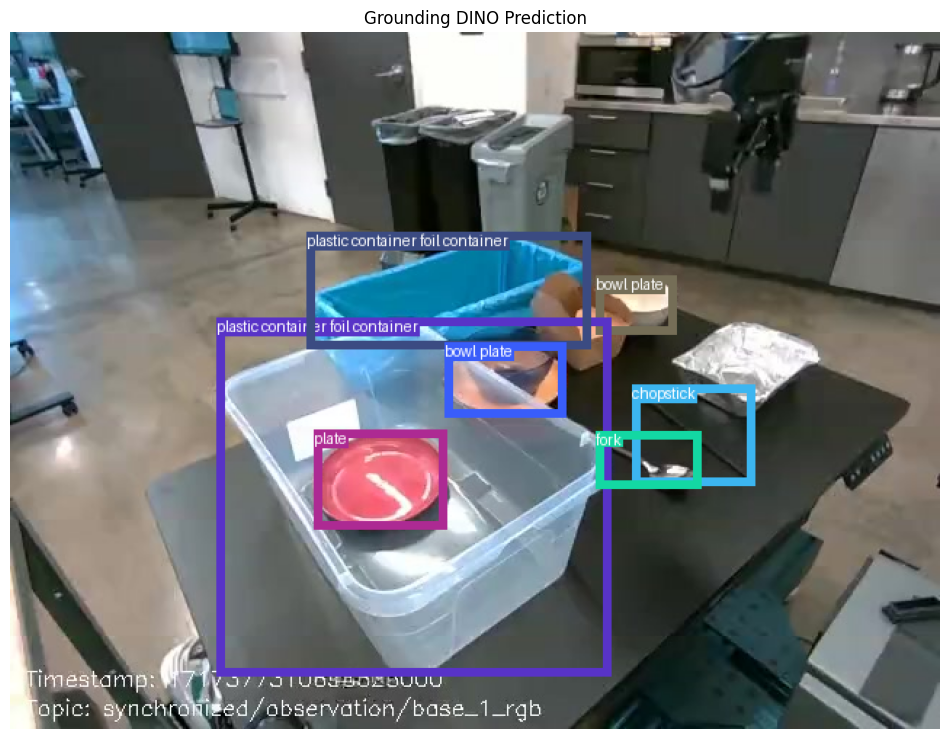

In [44]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

image_with_boxes = plot_boxes_to_image(image_pil, input_boxes, class_names)

# Display the image
plt.figure(figsize=(12, 12))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Grounding DINO Prediction")
plt.show()

## Run SAM on this 

In [45]:
OBJECTS = class_names

ID_TO_OBJECTS = {i+1: obj for i, obj in enumerate(OBJECTS)}
print(f"OBJECTS ARE: {OBJECTS}")
print(f"ID_TO_OBJECTS ARE: {ID_TO_OBJECTS}")

OBJECTS ARE: ['bowl plate', 'plate', 'plastic container foil container', 'plastic container foil container', 'bowl plate', 'chopstick', 'fork']
ID_TO_OBJECTS ARE: {1: 'bowl plate', 2: 'plate', 3: 'plastic container foil container', 4: 'plastic container foil container', 5: 'bowl plate', 6: 'chopstick', 7: 'fork'}


In [46]:
img_path = os.path.join(video_dir, frame_names[ann_frame_idx])
image = Image.open(img_path)

# prompt SAM image predictor to get the mask for the object
image_predictor.set_image(np.array(image.convert("RGB")))

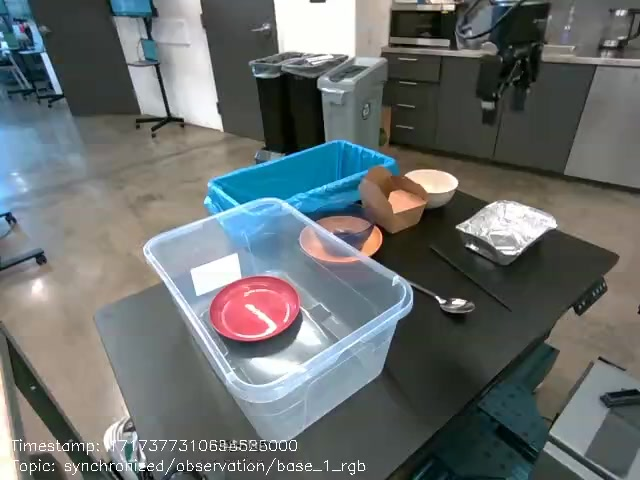

In [13]:
image

In [52]:
def normalize_to_pixel_coordinates(normalized_boxes, image_width, image_height):
    pixel_boxes = []
    for box in normalized_boxes:
        center_x, center_y, width, height = box
        x_min = (center_x - width / 2) * image_width
        y_min = (center_y - height / 2) * image_height
        x_max = (center_x + width / 2) * image_width
        y_max = (center_y + height / 2) * image_height
        pixel_boxes.append([x_min, y_min, x_max, y_max])
    return np.array(pixel_boxes)

# Get image dimensions
image_width, image_height = image.size

# Convert normalized boxes to pixel coordinates
input_boxes = normalize_to_pixel_coordinates(input_boxes, image_width, image_height)


In [53]:
input_boxes

array([[403.74466419, 168.30714047, 458.86161327, 208.78409564],
       [209.08991337, 274.78993535, 300.05837917, 342.35903621],
       [142.66814232, 197.24098206, 413.0328083 , 443.65922928],
       [204.03935432, 138.91036034, 399.28076744, 218.45357895],
       [299.14012432, 214.83098567, 382.71725178, 265.09165227],
       [428.91740322, 243.06570411, 512.2377634 , 312.10000634],
       [403.0927062 , 275.90902627, 475.82636118, 314.70464408]])

In [54]:
# prompt SAM 2 image predictor to get the mask for the object
masks, scores, logits = image_predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

# convert the mask shape to (n, H, W)
if masks.ndim == 3:
    masks = masks[None]
    scores = scores[None]
    logits = logits[None]
elif masks.ndim == 4:
    masks = masks.squeeze(1)

In [55]:
scores

array([[0.9609375 ],
       [0.9765625 ],
       [0.95703125],
       [0.96875   ],
       [0.81640625],
       [0.8046875 ],
       [0.9140625 ]], dtype=float32)

Shape of masks: (7, 480, 640)
Data type: float32
Number of non-zero elements: 51984


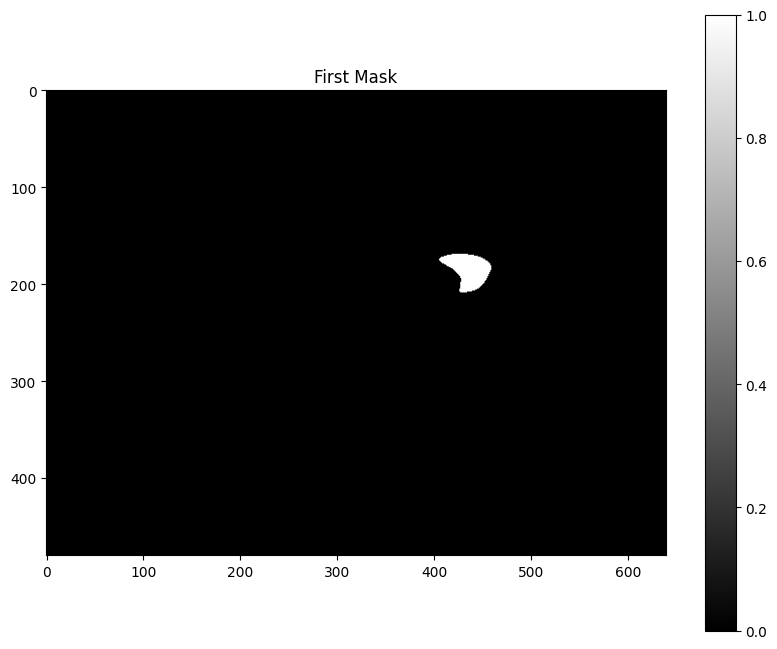

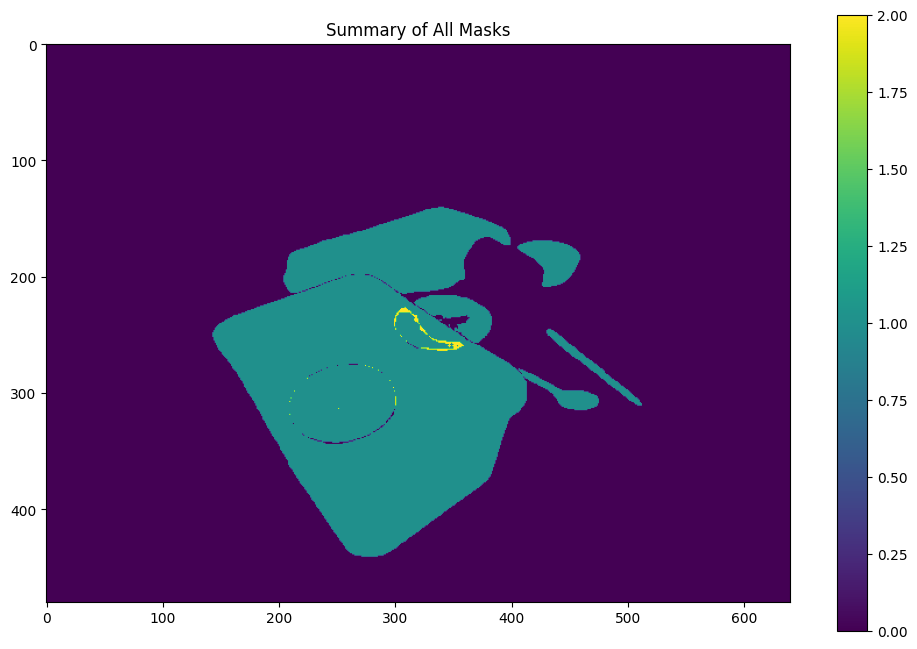

Mask 0:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0042, Std: 0.0644
  Non-zero pixels: 1278

Mask 1:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0157, Std: 0.1242
  Non-zero pixels: 4816

Mask 2:
  Min: 0.0000, Max: 1.0000
  Mean: 0.1104, Std: 0.3133
  Non-zero pixels: 33901

Mask 3:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0272, Std: 0.1627
  Non-zero pixels: 8360

Mask 4:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0074, Std: 0.0858
  Non-zero pixels: 2281

Mask 5:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0020, Std: 0.0449
  Non-zero pixels: 620

Mask 6:
  Min: 0.0000, Max: 1.0000
  Mean: 0.0024, Std: 0.0486
  Non-zero pixels: 728



In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'masks' is your variable with shape (16, 480, 640)
print(f"Shape of masks: {masks.shape}")
print(f"Data type: {masks.dtype}")
print(f"Number of non-zero elements: {np.count_nonzero(masks)}")

# Visualize a single mask
def plot_mask(mask, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot the first mask
plot_mask(masks[0], "First Mask")

# Plot a summary of all masks
plt.figure(figsize=(12, 8))
plt.imshow(np.sum(masks, axis=0), cmap='viridis')
plt.title("Summary of All Masks")
plt.colorbar()
plt.show()

# Print statistics for each mask
for i in range(masks.shape[0]):
    mask = masks[i]
    print(f"Mask {i}:")
    print(f"  Min: {mask.min():.4f}, Max: {mask.max():.4f}")
    print(f"  Mean: {mask.mean():.4f}, Std: {mask.std():.4f}")
    print(f"  Non-zero pixels: {np.count_nonzero(mask)}")
    print()

## Step 3: Register each object's positive points to video predictor with separate add_new_points call

In [58]:
PROMPT_TYPE_FOR_VIDEO = "box"  # or "point" or "mask"

assert PROMPT_TYPE_FOR_VIDEO in ["point", "box", "mask"], "SAM 2 video predictor only support point/box/mask prompt"

# If you are using point prompts, we uniformly sample positive points based on the mask
if PROMPT_TYPE_FOR_VIDEO == "point":
    # sample the positive points from mask for each objects
    all_sample_points = sample_points_from_masks(masks=masks, num_points=10)
    for object_id, (label, points) in enumerate(zip(OBJECTS, all_sample_points), start=1):
        labels = np.ones((points.shape[0]), dtype=np.int32)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            points=points,
            labels=labels,
        )
# Using box prompt
elif PROMPT_TYPE_FOR_VIDEO == "box":
    for object_id, (label, box) in enumerate(zip(OBJECTS, input_boxes), start=1):
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            box=box,
        )
# Using mask prompt is a more straightforward way
elif PROMPT_TYPE_FOR_VIDEO == "mask":
    for object_id, (label, mask) in enumerate(zip(OBJECTS, masks), start=1):
        labels = np.ones((1), dtype=np.int32)
        _, out_obj_ids, out_mask_logits = video_predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=object_id,
            mask=mask
        )
else:
    raise NotImplementedError("SAM 2 video predictor only support point/box/mask prompts")

## Step 4: Propagate the video predictor to get the segmentation results for each frame

In [59]:
def get_mask_coordinates(mask):
    return np.column_stack(np.where(mask))

video_segments = {}  # video_segments contains the per-frame segmentation results
mask_coordinates = {}  # To store mask coordinates for each frame and object
for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    
#     # Extract and store coordinates
#     mask_coordinates[out_frame_idx] = {
#         out_obj_id: get_mask_coordinates(video_segments[out_frame_idx][out_obj_id])
#         for out_obj_id in out_obj_ids
#     }

# # Save mask coordinates to a file
# with open('mask_coordinates.json', 'w') as f:
#     json.dump({str(k): {str(k2): v2.tolist() for k2, v2 in v.items()} 
#                for k, v in mask_coordinates.items()}, f)


propagate in video:   0%|          | 0/614 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 614/614 [00:53<00:00, 11.52it/s]


In [36]:
"""
Step 6: Visualize the segment results across the video and save them
"""
SAVE_TRACKING_RESULTS_DIR = "./tracking_results_3"
if not os.path.exists(SAVE_TRACKING_RESULTS_DIR):
    os.makedirs(SAVE_TRACKING_RESULTS_DIR)

ID_TO_OBJECTS = {i: obj for i, obj in enumerate(OBJECTS, start=1)}
for frame_idx, segments in video_segments.items():
    img = cv2.imread(os.path.join(video_dir, frame_names[frame_idx]))
    
    object_ids = list(segments.keys())
    masks = list(segments.values())
    masks = np.concatenate(masks, axis=0)
    
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks),  # (n, 4)
        mask=masks, # (n, h, w)
        class_id=np.array(object_ids, dtype=np.int32),
    )
    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)
    label_annotator = sv.LabelAnnotator()
    annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=[ID_TO_OBJECTS[i] for i in object_ids])
    mask_annotator = sv.MaskAnnotator()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    cv2.imwrite(os.path.join(SAVE_TRACKING_RESULTS_DIR, f"annotated_frame_{frame_idx:05d}.jpg"), annotated_frame)
